<a href="https://colab.research.google.com/github/ShrimanthAM/DeepLearningClass/blob/master/Chapter_4_Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/MPDL Fall 2020/')

from mpdl import train_simple_network

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from mpdl import train_simple_network, Flatten, weight_reset

Mounted at /content/gdrive/


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [ ]:
torch.backends.cudnn.deterministic=True
from mpdl import set_seed, moveTo
set_seed(42)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

The previous chapter showed us how to develop neural networks for a specific type of spatial structure, spatial locality. Specifically we learned how the convolution operator endowed our neural network with a prior that items near each other are related, but far away items have _no_ relationship. This allowed us to build neural networks that learned faster and more accurate solutions for classifying images. 

Now we want to develop models that can handle a new type of structure. In this case, _sequences_ where we have $T$ items that occur in a specific order. For example, the alphabet "a, b, c, d, ..." is a sequence of 26 characters. Each sentence of this book could be thought of as a sequence of words _or_ a sequence of characters. If you wanted to try and predict the weather, you could use the temperature every hour as a sequence to try and predict the temperature in the future. So long as each item in the sequence can be represented as a vector $\boldsymbol{x}$, we will be able to use a sequence based model to learn over it. For example, videos can be treated as a sequence of images you could use a CNN to convert each image into a vector!\footnote{This is a real type of model that people train, but it tends to take a long time to train. So we won't do any examples that are quite that complex.} 

In all of these cases, the structure is uniquely different compared to images and convolution from the last chapter. Sequences can have a _variable_ number of items in each sequence. For example, the two previous sentences have variable length: 19 and 11 words respectively. By comparison images were _always_ the exact same width and height. This was not too restricting for images since it is easy to resize images without changing their meaning. But we can't just "resize" a sequence. So we need an approach that can handle this new problem of variable length data. 

That is where Recurrent Neural Networks (RNNs) come into play. They give us a different prior for our model: that inputs follow a sequence and that order matters. RNNs are particularly useful because they are able to handle inputs with differing sequence lengths. When talking about sequences and RNNs, we will often refer to the sequence as a "time series" and the $i$'th item in the sequence as the $i$'th "step in time" (using $t$ and $i$ to denote a specific item/point in time are both common and we will use both).  This comes from a view of RNNs as processing a sequence of events at a regular interval. This terminology is prevalent, and so well use $T$ for "time" to refer to the number of items in the input sequence. Using the first two sentences from the last paragraph again, that would be $T=19$ for 19 words in the first sentence, and $T=11$ for 11 words in the second sentence.  

RNNs are often one of the more challenging concepts for people to grasp when diving into deep learning. For this reason we are going to carefully build our way up to understanding what an RNN actually is. This begins with the concept of weight sharing, where we can re-use the same weights (our parameters $\Theta$) to process multiple inputs. Well show how we can apply this weight sharing concept to handle the variable number of inputs and work our way to a simple RNN approach that is the foundation of more advanced methods. Then we will focus on how to perform simple classification problems over a sequence, and how to implement them in PyTorch. 

# Recurrent Neural Networks as Weight Sharing

Before we get into the fancy new topic of Recurrent Neural Networks (RNNs), lets talk a bit more about a concept from last lecture, _weight sharing_. To make sure you are familiar with this fundamental idea, we are going to walk through solving a contrived problem with weight sharing. That way we can show the actual mechanics of the process before diving into the more complex RNN. 

When using a CNN, the convolution operation is like having a single small linear network that we slide across the image, applying the _same function to every spatial position_. This is an implicit property of a CNN, that we made explicit with this small bit of code.
```python
x = torch.rand(D)#some input vector
output = torch.zeros(D-K//2*2)
for i in range(output.shape[0]):
    output[i] = f(x[i:i+K], theta)
```

The above code shows the idea of weight sharing, re-using the same weights $\Theta$ for multiple inputs. Our CNN does this implicitly. To help us understand RNNs and how they work, we are going to walk through explicitly applying weight sharing to show how we can use weight sharing in different ways. Then we can  adjust how we leverage weight sharing to arrive at the original RNN algorithm.  

## Weight Sharing 

To start, lets imagine we want to create a fully connected network with three hidden layers for a classification problem. We can write out the math for our network as: 

$$f(\boldsymbol{x}) = \text{tanh}\left( \text{tanh}\left( \text{tanh}\left(\boldsymbol{x}^\top \boldsymbol{W}^{(h_1)}_{d \times n}\right) \boldsymbol{W}^{(h_2)}_{n \times n}  \right) \boldsymbol{W}^{(h_3)}_{n \times n}  \right) \boldsymbol{W}^{(\text{out})}_{n \times \text{classes}}$$

I've decided to be explicit with this equation and show the shapes of each linear layer. We have $d$ input features according to this equation, $n$ neurons in each hidden layer, and "$\text{classes}$" outputs. This explicit detail will become important in a moment.  Now, lets quickly implement this network for MNIST. 


In [ ]:
mnist_data_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())
    
mnist_train_loader = DataLoader(mnist_data_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_data_test, batch_size=64)

#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images 
#Hidden layer size
n = 256 
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10

#Create our regular model 
model_regular = nn.Sequential(
  Flatten(), 
  nn.Linear(D, n), 
  nn.Tanh(),
  nn.Linear(n, n), 
  nn.Tanh(),
  nn.Linear(n, n), 
  nn.Tanh(),
  nn.Linear(n, classes),
)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


This is a simple fully connected model since we have used `nn.Linear` layers. To train this as a classification problem, we again use the `train_simple_network` function. This should all be familiar from chapters 2 and 3. We can train this model and get a result (below code), which is nothing new yet. 

In [ ]:
loss_func = nn.CrossEntropyLoss()
regular_results = train_simple_network(model_regular, loss_func, mnist_train_loader, val_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

Now, lets _pretend_ that this is a very large network. So large, we can not fit the weights for all three hidden layers $\boldsymbol{W}^{(h_1)}_{d \times n}$, $\boldsymbol{W}^{(h_2)}_{n \times n}$, $\boldsymbol{W}^{(h_3)}_{n \times n}$. But we _really_ want a network with three hidden layers. One options is to _share_ the weights between some of the layers. We can do this mathematically by simply replacing $h_3$ with $h_2$ again. So the equation changes to:

$$f(\boldsymbol{x}) = \text{tanh}\left( \text{tanh}\left( \text{tanh}\left(\boldsymbol{x}^\top \boldsymbol{W}^{(h_1)}_{d \times n}\right) \boldsymbol{W}^{(h_2)}_{n \times n}  \right) \color{red}{\boldsymbol{W}^{(h_2)}_{n \times n}}  \right) \boldsymbol{W}^{(\text{out})}_{n \times \text{classes}}$$

The only thing that has changed (in red) is we are re-using the weights $\boldsymbol{W}^{(h_2)}$ in two different locations. _This is weight sharing_, reusing the weights of  a layer! Its called such because we could pretend the two different usages of $\boldsymbol{W}^{(h_2)}$ are "different" layers in the network, that "share" the same weights.  How do we implement this in PyTorch? Its actually very simple. If we think of that linear layer as an object, we simply _reuse the layer object_. Everything else works exactly the same!

You may also hear weight sharing being called "tied" weights. This is the same concept, just a different analogy for the name: that the weights are "tied" together. Some people prefer this terminology if the weights are used slightly differently. For example, one layer may use $W$, while the other uses the transposed weights $W^\top$. 

The below code shows the same fully-connected network but with weight sharing for the second and third hidden layers! We declared the `nn.Linear` layer we wanted to share as an object named `h_2` and simply inserted it twice in the `nn.Sequential` list. So the `h_2` will be used as both the second and third hidden layer, and PyTorch will correctly train the network using the very same function, no changes need. 

In [ ]:
#Create the layer of weights of our network that we plan to share. 
h_2 = nn.Linear(n, n)
model_shared = nn.Sequential(
  Flatten(), 
  nn.Linear(D, n), 
  nn.Tanh(),
  h_2, #First use
  nn.Tanh(),
  h_2, #Second use, now sharing the weights!
  nn.Tanh(),
  nn.Linear(n, classes),
)

That the above code should work may seem trivial from a coding perspective. This is some very object-oriented design, we create an object, and the object is used in two places. But making the math work out is not a simple matter. Luckily PyTorch handles this for you and below you can see the same training function will handle this weight sharing just fine. 

In [ ]:
shared_results = train_simple_network(model_shared, loss_func, mnist_train_loader, val_loader=mnist_test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

With the new weight-shared network, we can now plot the validation accuracy of both to see what that 1) PyTorch  _really_ learn with shared weights, and 2) what the results look like. 

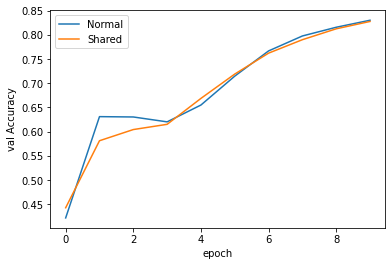

In [ ]:
#Now we can plot the results, and compare them!
sns.lineplot(x='epoch', y='val Accuracy', data=regular_results, label='Normal')
sns.lineplot(x='epoch', y='val Accuracy', data=shared_results, label='Shared')

You should see that using the weight sharing, we didn't take any longer to train, and we didn't lose any accuracy either (that is _not_ a guarantee!). We did get a nice benefit of slightly reduced memory, but what we have just done is rarely used. Better approaches exist to reduce memory usage, and the purpose of this "problem" was really to just demonstrate the concept of weight sharing and see how it can work. We care about weight sharing because it is the foundation for creating and training Recurrent Neural Networks. 



## Weight Sharing Over Time

Now that we understand weight sharing, we are going to show 

What happens if you have data that is measured over time. Lets say we have $T$ total units of time. Instead of having a single input $\boldsymbol{x} \in \mathbb{R}^d$, we will have $T$ inputs $\boldsymbol{x}_1, \boldsymbol{x}_2, \ldots, \boldsymbol{x}_{T-1}, \boldsymbol{x}_T$. Where each input is a vector is of the same size (i.e., $\boldsymbol{x}_j \in \mathbb{R}^d$). Remember that each $\boldsymbol{x}_1, \boldsymbol{x}_2, \ldots, \boldsymbol{x}_{T-1}, \boldsymbol{x}_T$ is a vector representation of something that is sequential. For example, the weather could have a vector with the high, low, and average temperate each day ($\boldsymbol{x}_t= [\text{high}, \text{low} , \text{mean}]$), and the days must occur in their natural order (no time traveling allowed!). 

How do we process something over time? If we have a network module $A$, where $A(\boldsymbol{x}) = \boldsymbol{h}$. We could use weight sharing to apply the network module $A$ to every item independently. So we would get $T$ outputs, $\boldsymbol{h}_i = A(\boldsymbol{x}_i)$. We will eventually use one of these outputs $\boldsymbol{h}$ as the input to a linear layer, but first we need to work our way to an RNN. The naive approach of applying $A(\cdot)$ independently is shown in the below diagram.

![A naive solution using a network module $A$ to process $T$ different inputs in a sequence independently. Each item in the sequence $x_i$ is processed independently of every other sequence. This does not recognize the sequential nature of the data, because there is no path connecting $\boldmath{x}_t$ and $\boldmath{x}_{t+1}$ . ](https://drive.google.com/uc?export=view&id=1HEDDS0ARrDJU_GhTpOOIQSK71L6SGlZx)


We used weight sharing to apply the same function/layer $A(\cdot)$ to each item over time. But we did not do anything to connect information _over_ time! So lets define a new version of this layer $A$, that has a _recurrent_ weight. We've used $h_i$ to indicate the result from time step $i$, so lets incorporate that into our model. 

$$A(\boldsymbol{h}_{i-1}, \boldsymbol{x}_i) = \boldsymbol{h}_i = \tanh(\boldsymbol{h}_{i-1}^\top \boldsymbol{W}^{\text{prev}}_{n \times n} + \boldsymbol{x}_i^\top \boldsymbol{W}^{\text{cur}}_{d \times n})$$

Now we have one set of weights ($\boldsymbol{W}^{\text{cur}}_{d \times n}$) that take in the _current_ time step ($\boldsymbol{x}_i$) that are added to a second set of weights ($\boldsymbol{W}^{\text{prev}}_{n \times n}$) for the _previous_ time step's result ($\boldsymbol{h}_{i-1}$).   By re-using this new function at each time step, we get information across time! This is all shown in the below diagram. 

![The network $A$ is defined to take in two inputs, the previous hidden state $h_{t-1}$ and the current input $x_t$. This allows us to "unroll" the network, and shares information across time. This does effectively deal with the sequential nature of the data. ](https://drive.google.com/uc?export=view&id=1CsaRu7QVdlAfwTtAk6dnjl_nXUoy0SBm)



This approach to sharing information across time defines a basic recurrent neural network. It can be hard to wrap your head around initially. The idea is that we are re-using the _same function and weights_ $A$ at every time step. At time step $t$ the model gets information about the past  from the hidden state $\boldsymbol{h_{t-1}}$.  Because $\boldsymbol{h_{t-1}}$ was computed from $\boldsymbol{h_{t-2}}$, it actually has information from the past _two_ time steps. And since $\boldsymbol{h_{t-2}}$ depends on $\boldsymbol{h_{t-3}}$, its actually _three_ previous steps. You keep following this back to the default value of $\boldsymbol{h_{0}}$, and you can see how $\boldsymbol{h_{t-1}}$ has information from every previous time step based on the order of those time steps. Thats how RNNs capture information over time. But what do we do at the start of time ($i=1$) when we would need $\boldsymbol{h}_{0}$ which does not exist? Implicitly we assume that $\boldsymbol{h}_{0} = \vec{0}$ (i.e., a vector of all zeros) to make things complete. The 

![An example of unrolling the RNN for $T=3$ time steps. Here we explicitly draw out where each input ($\boldsymbol{x_t}$) and hidden activation ($\boldsymbol{h_t}$) in the process. The initial hidden state $\boldsymbol{h_0}$ is always set to a vector of all zero values. Notice that it now looks like a feed-forward model. ](https://drive.google.com/uc?export=view&id=15EsKFtjqXv7k1HRZdN0fXI62oenmEUpz)


It can be helpful to draw this out more explicitly, as shown in the above figure. This is often called "unrolling" the RNN over time. Notice how it is starting to look eerily similar to a fully-connected network now! The only difference is that we have multiple inputs, $\boldsymbol{x_1}, \ldots, \boldsymbol{x_T}$, one for each time step. For simple classification problems, we will use the last activation $\boldsymbol{h}_T$ as the result to make a prediction from because $\boldsymbol{h}_T$ has information from every previous time step, and it is the last time step. This makes $\boldsymbol{h}_T$ the only step with information about the _entire_ sequence.   The fact that we can unroll an RNN like this is the reason we are able to use the same algorithms to train it. This is the essence of what an RNN is. 

# RNNs in PyTorch

Now that we know what an RNN is, we need to figure out how to use one within PyTorch. While a lot of code is provided for us to accomplish this goal, there is still a good amount of code and work we need to build ourselves. Like everything in this book, first will be to create a `Dataset` that represents our data and loads it, followed by a `model` that uses the PyTorch `nn.Module` class that takes the input data and produce some kind of prediction. But for RNNs we need vectors, and most of the data we will use is _not_ naturally represented as a vector. This means we will need to do some extra work to fix that. The below diagram shows the steps that we need to implement to get this working. 


![](imgs/chp4/rnn_pred_diagram.png)

To represent sequence data for an RNN in PyTorch we will use a three dimensional input representation:

$$(B, T, D)$$

Like before, $B$ tells us how many items in a batch (i.e., how many data points) we will be using. $T$ gives us the total number of time steps, and $D$ is how many features are present per time step. Because time is represented in the tensor object itself, its easy for us to specify the model. 

Lets start simple by creating a many-to-one classification problem. What do I mean by this? We will have many inputs (every time step!), but we will have only _one_ output, the class label we are trying to predict. 

## A Simple Sequence Classification Problem

To create a model, we first need data. This is getting us to step 1 of \autoref{fig:rnn_pred_diagram}. To keep things simple we will borrow the task from the [PyTorch RNN tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html), which is to identify the language a name came from. For example, "Steven" would be an English name. Note that this is a problem that can't be solved perfectly. For example, "Frank" could be English or German. So we should expect some errors due to these issues / oversimplification. Our goal is to make code that embodies the below process:

![RNN process for classifying a name's source language. The individual characters of a name make the sequence that is feed into the RNN. We will learn 1) how to convert each character into a vector, 2) how to get an RNN to process that sequence and return a final activation $\boldsymbol{h}_T$, and 3) end with a linear layer that produces a prediction.   ](https://drive.google.com/uc?export=view&id=1Wg8TYS9FhStvAqDrVwGMoI62UjPlcghC)

The code below will download the dataset for us and and extract all of the files. Once complete, the folder structure is `names/[LANG].txt`, where `[LANG]` indicates the language (which is also the label for this problem), and the content of the text file is a list of names that occur in that language. 

In [ ]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

#Zip file is organized as data/names/[LANG].txt , where [LANG] is a specific language

Since this data is pretty small, we are going to load all of it into memory with the below code. All the data will be stored in a dictionary `namge_language_data`, which maps the language name (e.g., "English") to a list of all the names. To simplify our lives, the `unicodeToAscii` will remove non-ASCII characters from each name. The dictionary `alphabet` will contain all of the characters we expect to see, and _map every item to a unique integer, starting from 0 and increasing sequentially_. 

This is important. Our computers have no idea what any character or "item" you might have in your sequence means. Unless you data naturally exists as numeric values (e.g., the temperature outside), a conversion step is going to be needed. We will get to _how_ that conversion is done in a moment, but we standardize this process by mapping every unique item that may occur in a sequence to a unique integer value. 

In [ ]:
namge_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too. 

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


Now we have created a dataset, which may may notice is not well balanced. THere are _far_ more Russian names than any other language. Other languages like Vietnamese only have 73 names! This is something we should be on the lookout for when evaluating our model. 

With our data loaded in memory, we can now implement a `Dataset` to represent it. The `data` list will contain each name, and an associated index in the `labels` list will indicate which specific language the name came from. A  `vocabulary` dictionary will map  every unique item to an integer value. The whole code is below. 

The concept of a "vocabulary" is very common in machine learning and deep learning. You will often see the math symbol $\Sigma$ used to denote the vocabulary. For example, we could ask "is the word _cheese_ in the vocabulary" more succinctly by writing $\text{"cheese"} \in \Sigma$. If we wrote $\text{"blanket"} \notin \Sigma$ then we would be indicating that the item "blanket" is not in the vocabulary.  We can also denote the size of the vocabulary using $|\Sigma|$. 

In [ ]:
class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

The `__len__` function is straight forward, it returns the total number of data points within the `Dataset`. The first interesting function is the helper function `string2InputVec`, which takes an `input_string` in and returns a new `torch.Tensor` as the output. The tensor's length is the number of characters as the `input_string`, and has the `torch.long` type (also known as `torch.int64`). The values in the tensor than indicate which unique token was present in the `input_string` and their order. This gives us a new tensor based "representation" that PyTorch will be able to use. 

This  `string2InputVec` is then reused in our `__getitem__` method. We grab the original string from the `self.data[idx]` member, and convert it into the Tensor representation PyTorch needs using `string2InputVec`. The returned value is a tuple following the pattern of $(\text{input}, \text{output})$. For examples might look like:
```python
(tensor([10,  7, 14, 20, 17, 24]), 0)
```
Which indicates that a name with six characters that should be classified as the first class (Arabic). The original string was converted to a tensor of integers by our `string2InputVec` function so that PyTorch will be able to understand it. 

With that, we can create a new dataset for this task of determining the language of a given name. This is in the below code snippet, where we create a train/test split with 300 items in the test split. Notice that we are also going to use a batch size of just 1 in the loaders. We will come back to this nuance detail later in this chapter. 

In [ ]:
dataset = LanguageNameDataset(namge_language_data, alphabet)

train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

\title{Stratified Sampling for Class Imbalance}

This dataset has an issue of _class imbalance_ that we are not tackling at the moment. This occurs when the ratio of classes is uneven. In this setting, the model may sometimes learn to simply reiterate the most common class label. For example, imagine you are trying to predict if someone has cancer. You can make a model that is 99.9% accurate by _always_ predicting "no cancer". This is because, thankfully, most people do not have cancer at a given moment in time. But this is not useful for a model. 

Solving class imbalance is it's own niche topic area, and we are not going to go into much detail about it. But one simple improvement that could be made is to use _stratified_ sampling to create the train/test split. Its a common tool and available in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html). The idea is that you want to _force_ the sampling to maintain the class ratios in the splits. So if the original data is 99% A and 1% B, you want your stratified splits to have the same percentages. With random sampling, you could easily end up with 99.5% A, and 0.5% B. Normally this is not a huge issue, but when you have class imbalance, and can highly skew your perception of how well a model is doing. 

Now that we have the dataset loaded, we can talk about the remaining parts of our RNN model inside of PyTorch. 

## Embedding Layers

In order to complete step 1 of \autoref{fig:rnn_pred_diagram}, we first needed to implement our `Dataset` class such that it returned a tensor of length $T$ (the number of characters in a name) storing  integer values (a unique value for every character). We call all the unique items (the characters "a", "b", "c", etc.) and their mapping from identity to index ("a" becomes 0, "b" becomes 1, etc) our "vocabulary". This is all standard terminology used withing the deep learning community that you should become familiar with. 

The next step to creating a vector from this representation is to create an _embedding_ layer. Embedding layers are lookup tables designed to map each integer value to a specific vector representation. You tell the embedding layer how large the vocabulary is (i.e, how many unique items exist) and how large you want the dimension to be. The below diagram shows how this process works at a conceptual level. 

![Embedding layer designed to take in a vocabulary of 5 unique items. You have to write the code that maps objects (like strings) into integers. The embedding maps each integer to it's own $d$-dimensional vector $\boldsymbol{x} \in \mathbb{R}^d$. ](https://drive.google.com/uc?export=view&id=1e-hMBcgZO370Gp9fqS4QwI9H_YKp3TxH)

In this toy example the vocabulary contains both characters and words. The vocabulary does not even need to be strings! So long as you can consistently map the items to a integer value. The `nn.Embedding`'s first argument is `5` to indicate that the vocab has five unique items. The second argument `3` is the output dimension. You should think of this in the same kind of manner as the `nn.Linear` layer, where the 2nd argument tells you how many outputs will exist. We could increase or decrease the output size based on how much information we think the model needs to be able to pack into each vector. In most applications, you will want to try values in the range of $[64, 256]$ for the number of output dimensions.  

The `nn.Embedding` layer is designed to work with sequences of things. That means its possible for the sequence to contain 
repetitions. For example, the below code snippet creates a new input sequence with $T=5$ items in it, but a vocabulary of only $3$ items. This is OK because the input sequence $[0, 1, 1, 0, 2]$ has repetitions (0 and 1 occur twice). The `embd` object is created with a dimension of $d=2$, and processes the input to create a new representation `x_seq`. 

In [ ]:
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)
    print(input_sequence.shape, x_seq.shape)
    print(x_seq)

torch.Size([5]) torch.Size([5, 2])
tensor([[ 0.2901, -0.1421],
        [ 0.0644,  0.2646],
        [ 0.0644,  0.2646],
        [ 0.2901, -0.1421],
        [-2.4576,  0.4318]])


This `x_seq` would be the tensor representation that is now compatible with all of the standard tools of deep learning. Notice that its shape is now $(5,2)$, and you will see random values filled in. Thats because the `Embedding` layer initializes everything to random, and these values are altered by gradient descent as the network is trained. But, you will also see that the 1st and 4th rows of the matrix have the exact same values, as do the 2nd and 3rd. This is because the order in the output matches the order in the input! The unique item denoted by "0" was at the 1st and 4th positions, so the same vector will be used in both places. Same for the unique item denoted by "1" which was repeated as the 2nd and 3rd item. 

When working with strings, or any other content that does not naturally exist as "vectors", you will almost always want to use an Embedding layer as your first step. This is the standard tool for converting these abstract concepts to representations we can work with, and completes step 1 of  \autoref{fig:rnn_pred_diagram}. 

## Last Time Step

The task of using an RNN within PyTorch is actually quite easy, as PyTorch provides implementations of the standard RNN algorithm for you. The trickier part is to extract the last time step $\boldsymbol{h}_T$ after being processed by the RNN. We want to do this because the last time step is the _only_ one that caries information from all $T$ inputs based on the input's order. This way we can use $\boldsymbol{h}_T$ as a fixed length summary of the input data for a fully-connected sub-network. This works because $\boldsymbol{h}_T$ will have the same shape and size, no matter how long the input sequence is! So if our RNN layer has 64 neurons, $\boldsymbol{h}_T$ will be a 64-dimension vector represented as a tensor of shape $(B, 64)$. It does not matter if our sequence has one item $T=1$, or $T=100$ items, it will always be the case that $\boldsymbol{h}_T$ will have shape $(B, 64)$.  This processes is shown in the below figure.  

![Parts of applying an RNN to predict a label for a sequence. The output of the RNN is a sequence of hidden states $h_1, h_2, \ldots, h_T$. The last time step $h_T$ contains information about the entire sequence, so we want to use it as a representation for the whole sequence. That way it can go into a normal fully-connected network $f(\cdot)$.](https://drive.google.com/uc?export=view&id=1Kdjsv4HbcFBG6SJbzYbH9et6LFH0DAeg)

We need to implement a new `Module` that extracts the last time step before we can specify a RNN architecture in PyTorch. There are a few idiosyncrasies in how PyTorch stores this information that need to be dealt with. We need to know two things: the number of layers and if the model was bidirectional. This is because the RNN will return enough information for us to extract the result from any layer, giving us the flexibility to implement other kinds of models that we will discuss later. We talk about what "bidirectional" means later in this chapter. 

The below code is based on content from PyTorch's documentation and does the work to extract the  `LastTimeStep` $\boldsymbol{h}_T$ from an RNN. Depending on the specific RNN we use (more on that in two chapters!) the output of an RNN `Module` is a tuple of two tensors or a nested tuple of three tensors, with the last time step's activation stored in the second item of the tuple.  

In [ ]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple):#unless it's a tuple, 
            last_step = last_step[0]#then h_t is the first item in the tuple
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        #reshaping so that everything is separate 
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

The output of an RNN in PyTorch is a tuple of shape $(out, \boldsymbol{h}_T)$ or $(out, (\boldsymbol{h}_T, \boldsymbol{c}_T))$. The $out$ object has information about _every_ time step, and $\boldsymbol{h}_T$ contains information about only the _last_ time step but for _every_ layer. So we will check if the 2nd item is a `tuple` and extract the right $\boldsymbol{h}_T$ object. The value $\boldsymbol{c}_T$ is an extract "context" tensor, which is part of a more advanced RNN that we will discuss in chapter 6. 

Once we have $\boldsymbol{h}_T$, PyTorch is going to provide it as an input that has been `flatten()`-ed. We can use the `view` function to re-shape the tensor with information about the layers, bidirectional content (again, we will talk about that soon), the batch size, and the number of neurons $d$ in the hidden layer. We know we want the last layer's results, so we can index in and then use the `permute` function to move the batch dimension to the front. 

That then gives us what we need to extract the last layer of an RNN! This gives us the tools to implement steps 2 and 3 from \autoref{fig:rnn_pred_diagram}. The 4'th step is to use some kind of fully connected layer, which we already know how to do using a `nn.Linear` layer. The below code does the work of all four steps in total. The variable `D` will be the size of the `nn.Embedding` result,  `hidden_nodes` the number of neurons in the RNN, and `classes` the number of classes we are trying to predict (in this application, thats the number of different languages a name may have come from). 

In [ ]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  #the tanh activation is built into the RNN object, so we don't need to do it here!
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

When working with RNNs, we often have a lot of complex tensor shapes occurring at once. For this reason I try to always include a comment on each line indicating how the tensor shapes are changing as the result of each operation. The input batch is processing $B$ items with a length of up to $T$, so the input has a shape of $(B, T)$. The `nn.Embedding` layer converts this to a shape of $(B, T, D)$ - adding the `D` dimensions from the embedding. 

The RNN takes inputs of shape $(B, T, D)$ only if we specify that `batch_first=True`. While the rest of PyTorch  assumes batch first, RNNs and sequence problems often assume that the batch dimension comes third. In early implementations, having the tensors shaped this way made them significantly faster due to low-level technical details that we are not going to get into. While that representation order can still be faster, the gap is not as big today. So I prefer to use the `batch_first` option to make it more consistent with the rest of PyTorch as a whole. 

The RNN classes in PyTorch apply non-linear activation functions on their own. They are implicit in this case. This is another case where the behavior of PyTorch for RNNs is different from the rest of the framework. For this reason you should _not_ apply any non-linear activation function afterwards, because it has already been done for you! 

The RNN will return a `tuple` of at least two tensors, but our `LastTimeStep` module is designed to take this in and return a fixed length vector by extracting $h_T$ from the last time step. Since $h_T \in \mathbb{R}^D$ and we are processing $B$ items in a batch, that gives us a tensor of shape $(B, D)$. This is the same shape that our fully-connected networks expect! That means we can now just use standard fully-connected layers. In this case, we can use just one to create a linear layer that makes the final prediction. With that, we can again use the `train_simple_network` function to train our first RNN!

In [ ]:
loss_func = nn.CrossEntropyLoss()
batch_one_train = train_simple_network(first_rnn, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5)

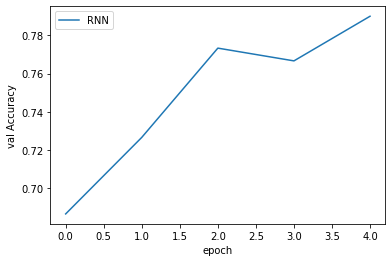

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=batch_one_train, label='RNN')

Now that we have trained our model, we can also play around with it. Lets try typing in a few names and seeing what the model thinks of them. Remember, we converted all names to lower case, so don't use any capital letters!

In [ ]:
pred_rnn = first_rnn.to("cpu").eval()

In [ ]:
with torch.no_grad():
    preds = F.softmax(pred_rnn(dataset.string2InputVec("frank").reshape(1,-1)), dim=-1)
    for class_id in range(len(dataset.label_names)):
        print(dataset.label_names[class_id], ":", preds[0,class_id].item()*100 , "%")

Arabic : 0.001415971837559482 %
Chinese : 0.14302297495305538 %
Czech : 10.405804961919785 %
Dutch : 2.882285416126251 %
English : 67.16553568840027 %
French : 0.16376073472201824 %
German : 14.552734792232513 %
Greek : 0.005317108298186213 %
Irish : 1.1402475647628307 %
Italian : 0.0932477880269289 %
Japanese : 0.0022939455448067747 %
Korean : 0.2901441650465131 %
Polish : 0.951843336224556 %
Portuguese : 0.018089264631271362 %
Russian : 0.395212322473526 %
Scottish : 1.3836015947163105 %
Spanish : 0.022123158851172775 %
Vietnamese : 0.3833228023722768 %


You should see that for a name like "Frank" we get the largest response for "English" and "German" as the source languages, which are both reasonable answers. Frank is a common name in English with German origins. You should try other names yourself and see how the behavior changes. This also shows how we can apply our RNN to variable length inputs! Regardless of the length of the input string, you still get a prediction out at the end. Where our previous examples with fully-connected or convolutional layers, the input had to _always_ be the exact same size. This is one of the reasons why we use RNNs is to resolve these kinds of issues.  

## A Note About Classification & Meaning
This example we have been working with is an over simplification of reality. Names do not necessarily come from _one_ specific language, which is something that is _implied_ by our model. Our model implies this because each name is labeled with one correct answer. This is an example of our model simplifying the world to make our lives easier from the modeling side. 

This example was chosen because it was readily available and we could make the examples small enough that they would run relatively quickly. But this is also a good opportunity for us to talk about some of the ethics involved in machine learning. When you make simplifying assumptions like this, they can be useful and help you solve real problems. But they can also alter how you think about the problem, and how the eventual users of you model think about the world too. For this reason you should make note of why you make these assumptions when modeling, what the model was for, and how it was validated. These are often called _model cards_. 

For example, consider our toy problem. If someone where to use it to try and determine a user's background and alter content displayed based on their name. Would this be _ok_? Probably not. You would need to have a good reason to want to alter content for someone's background, and need confidence int he correctness of the result and to the underlying question. Peoples' names may come from multiple reasons or backgrounds, and many may form their identity in different ways independent of their name or place of birth. So there is a good chance using this model in such a scenario isn't the best idea.

Predicting linguistic origins of names is not so painful a problem. But you now know enough techniques to recognize many common classification problems. For example, a common introductory problem is _sentiment classification_, where you attempt to determine if a sentence or document is conveying a positive, negative, or neutral sentiment. This can be useful and valid. For example, a food/beverage brand may want to monitor twitter to see if people are mentioning their product with a negative sentiment, so that they can investigate potential product failures or bad customer experiences. At the same time, positive, negative, and neutral are not the only sentiments, and a message could convey thoughts that are more complex. Making sure your users are aware of such limitations, and giving thought to these kinds of choices, is something to consider. If you want to learn more about the ethics and impact of these kinds of decisions, [Kate Crawford](https://www.katecrawford.net/) is an expert in this space who has some accessible readings at her website. 

# Improving Training Time With Packing

When building this model, we used a batch size of 1. This is not a very efficient way to train a model. So what happens if you go up and change the batch size to 2? Go on, try it! 

You should see that you get an error message. The problem is that each name is of a different length, so by default, it is very hard to represent as a tensor. Tensors need all dimensions to be consistent and the same, but our _time_ dimension (in this case, how many characters long each name is), is not consistent! This is what causes the error, we have two difference sequence with difference lengths. 

We saw in chapter 2 that training on batches of data can reduce the training time significantly by making better use of our GPU's compute. So we have a real reason to want to increase the batch size. Yet we appear to be stuck using an inefficient batch size of 1 due to inputs with differing sizes. 

This is an _abstraction_ problem, because fundamentally, nothing prevents an RNN on working with inputs of varying lengths of time. To fix this, PyTorch provides us with the [Packed Sequence](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.PackedSequence) abstraction. All types of Recurrent Neural Networks that are available in PyTorch support working on this class. 

The below image shows conceptually what is happening when we pack six different sequences of varying lengths. PyTorch will organize them by length, and begins by including the _first_ time step of all sequences in one _batch over time_. As time progresses, the shorter sequences reach their end, and the size of the batch is reduced to the number of sequences that have not reached their end. 

![Example of packing a batch of 5 items with sequence lengths of 3, 3, 4, 5, and 6. For the first three steps, we process all 5 sequences. On the fourth step $t=4$, two of the sequences have run out. So we drop them and continue the batch on only the sequences that have a length $\geq 4$. Packing organizes the data by length to make this fast an efficient. ](https://drive.google.com/uc?export=view&id=1cYAMY1O55UxvHMkbikqf0NpVXijYqqzE)

So lets talk though what is happening in this example. We are trying to train on a batch of 5 names, "ben", "sam", "lucy", "frank", and "edward". The packing process has sorted them from shortest to longest. There will be a total of $T=6$ steps in this sequence because "edward" is the longest name at 6 characters. This means our RNN will perform six iterations in total. Now lets talk about what happens at each step: 

1. First iteration all 5 items are processed together in one large batch.
2. All 5 items are again processed together in one large batch. 
3. All 5 items are again processed, _but_ we have reached the end of the first two items "ben" and "sam". We will record their final hidden states from _this_ step $\boldsymbol{h}_3$, since thats when they were finished being processed. 
4. A batch of only _3 items_ is done containing "lucy", "frank", and "edward". This is because the first two item's are done. So PyTorch will adaptively _shrink_ the effective batch size to what remains. "lucy" is finished, and it's final state saved as $\boldsymbol{h}_4$. 
5. A batch of only _2 items_ is done, and "frank" is finished after this step, so $\boldsymbol{h}_5$ is saved for "frank". 
6. The last step processing only 1 item, "edward", bringing us to the end of the batch and the final hidden state $\boldsymbol{h}_6$

Processing in this way ensures that we get the correct hidden state $h_T$ for each item despite the fact that they have different lengths. It also makes PyTorch run faster! We do more efficient batched computation for as much as possible, and shrink that batch as needed so we only work on the still valid data.  

### Pack and Pad

To implement this we need to override the _collate function_ used by the `DataLoader`. The collate function's job is to "collate" lots of independent data points into one larger batch of items. The default collate function can handle tensors so long as all tensors have the same shape. Our data will come in as a tuple $(\boldsymbol{x_i}, y_i)$ with shapes $(T_i)$ and $(1)$ respectively. Since $T_i$ can be different for each item, that would normally be a problem. So we need to define our new function which we will call `pad_and_pack`. Its a two-step process that is outlined below. 

![Steps of packing and padding input so that an RNN can be trained on batches of data, which with a different length.](https://drive.google.com/uc?export=view&id=1UheCZSRfbi4-UZD0lHkRJUVvTl0wsDyy)

The input gets passed to our function as a list objects. Every item in the tuple comes _directly_ from the `Dataset` class you use. So if you altered the `Dataset` to do something unique, this is how you would update the `DataLoader` to work with it! In our case: the `Dataset` returns a tuple of $(\text{input}, \text{output})$, so our `pad_and_pack` function will take in a list of tuples. The steps are to:

1. Store the length of every item. 
2. Create new lists of _just_ the inputs and _just_ the output labels
3. Create a _padded_ version of the input list. This makes all the tensors the same size, with a special token appended to the shorter items. PyTorch can do this for us using the `pad_sequence` function. 
4. Create the _packed_ version of the input using PyTorch's `pack_padded_sequence` function. This takes the padded version as input, along with the list of lengths, so that it knows how long each item was originally. 

Thats the high level idea, the below code implements it! 

In [ ]:
def pad_and_pack(batch):
    #1, 2, & 3: organize the batch input lengths, inputs, and outputs as seperate lists
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)
    #4: create the padded version of the input
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    #5: create the packed version from the padded & lengths
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    #Convert the lengths into a tensor
    y_batched = torch.as_tensor(labels, dtype=torch.long)
    #6: return a tuple of the packed inputs and their labels
    return x_packed, y_batched


You will notice two things about this code that we will mention. First is that we are setting an optional argument `batch_first=False`. This is because our input data does not yet have a batch dimension, it just has the length. If we had a batch dimension, and it was stored as the first dimension (the norm for most code), then we would set this value to be `True`. 

Second, for the packing step, we have the flag `enforce_sorted=False`. This is because we have chosen not to pre-sort the input batches by length. If we set `enforce_sorted=True` we would have gotten an error due to our inputs not being sorted. Older versions of PyTorch _required_ you to do this sorting yourself, but the current version will work just fine on unsorted inputs. It will still avoid unnecessary computations and is generally just as fast. So we chose this easier option. 

## Packable Embedding Layer

We need one more item before we can build our first RNN that can be trained in batches. It turns out the `nn.Embedding` layer from PyTorch does not handle packed inputs. I find its easiest to simply create a new wrapper `Module` that takes an `nn.Embedding` object in the constructor, and fixes it to handle packed inputs. This is shown in the below code. 


In [ ]:
class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects. 
    This wrapper class will fix that. If a normal input comes in, it will 
    use the regular Embedding layer. Otherwise, it will work on the packed 
    sequence to return a new Packed sequence of the appropriate result. 
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer 
    
    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input, 
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.to(input.data.device), 
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)


The first step is to check if the input is a `PackedSequence`. If not, we can just call the original `embd_layer` that we saved. If not, we need to first _unpack_ the input sequence. Notice that because our data is a packed _batch_ and the batch dimension is the _first_ dimension, we now have to set the `batch_first=True` flag. Unpacking gives us the original _padded_ `sequences` as well as their respective `lengths`. The next line simply performs the standard embedding on the unpacked `sequences`, making sure to move the `sequences` to the same compute device that the original `input.data` was on. Now that they are embedded, we then call `pack_padded_sequence` to again create a packed version of the now embedded inputs. 

## Training a Batched RNN

With our `EmbeddingPackable` module in hand with our new collation function `pad_and_pack`, we are ready to train an RNN on batches of data at a time! First we will need to create new `DataLoader` objects. This looks the same as what we have done before, except that we specified the optional argument `collate_fn=pad_and_pack`, so its now going to use the `pad_and_pack` function to create batches of training data. 

In [ ]:
B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, collate_fn=pad_and_pack)

In this case we have chosen to use a batch of 16 data points at a time. The next step is to define our new RNN module. We will use the `nn.Sequential` to build our model out of the `EmbeddingPackable`  to perform the embedding, followed by `nn.RNN` to create a RNN layer, followed by `LastTimeStep` to extract the final hidden states, and ending with a `nn.Linear` to perform a classification based on the input. 

In [ ]:
rnn_packed = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_packed.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(57, 64)
  )
  (1): RNN(64, 256, batch_first=True)
  (2): LastTimeStep()
  (3): Linear(in_features=256, out_features=18, bias=True)
)

Finally we can now train this model. This still works by calling our `train_simple_network`, because we have abstracted all the issues of packing and padding into the `collate_fn` and the `EmbeddingPackable` objects. Batch training is also much more efficient, so we are going to train for 20 epochs, thats four times as many as before! 

In [ ]:
packed_train = train_simple_network(rnn_packed, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)

If we look at the accuracy of this model, we should see that it is overall very similar to the one trained with a batch size of one, but perhapse a little bit worse. This is not unusual behavior for training an RNN. The weight sharing over time and multiple inputs can often make it difficult to learn RNNs in general. For this reason people often try to keep batch sizes for RNNs relatively smaller, because it can actually improve performance. But we will learn about techniques in the next two chapters that help solve this problem. 

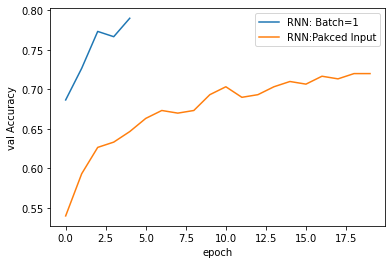

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=batch_one_train, label='RNN: Batch=1')
sns.lineplot(x='epoch', y='val Accuracy', data=packed_train, label='RNN:Pakced Input')

However, the above plot was looking at performance as a function of _epoch_. By packing the data into a larger batch, it was _much_ faster to train. If we look at accuracy as a function of the total time we had to wait, then packing becomes much more competitive! Lets look at that in the below plot. 

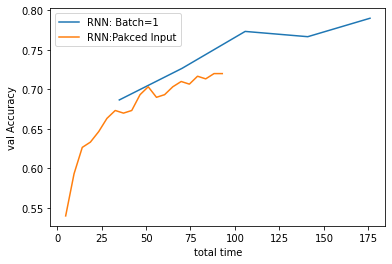

In [ ]:
sns.lineplot(x='total time', y='val Accuracy', data=batch_one_train, label='RNN: Batch=1')
sns.lineplot(x='total time', y='val Accuracy', data=packed_train, label='RNN:Pakced Input')

## Simultanious  Packed & Unpacked Inputs

The way we wrote our code has also given us a sneaky but small benefit. The RNN layers take in Packed Sequence objects _or_ normal tensors. Our new `EmbeddingPackable` also supports both types of inputs.  The LastTimeStep function we have been using always returns a normal tensor, because there is no reason / value to the "last" time step being "packed". For this reason, the same code we just wrote will work with _both_ packed and non-packed inputs! We can confirm this by again, trying to see if we can predict the linguistic origin of some new names! 

In [ ]:
pred_rnn = rnn_packed.to("cpu").eval()


In [ ]:
with torch.no_grad():
    preds = F.softmax(pred_rnn(dataset.string2InputVec("frank").reshape(1,-1)), dim=-1)
    for class_id in range(len(dataset.label_names)):
        print(dataset.label_names[class_id], ":", preds[0,class_id].item()*100 , "%")

Arabic : 0.3920009359717369 %
Chinese : 0.8008973672986031 %
Czech : 12.546056509017944 %
Dutch : 4.259283468127251 %
English : 45.94670832157135 %
French : 2.713760733604431 %
German : 13.930952548980713 %
Greek : 0.3517286852002144 %
Irish : 3.5775430500507355 %
Italian : 2.8647979721426964 %
Japanese : 0.14337095199152827 %
Korean : 0.6884720642119646 %
Polish : 3.2501738518476486 %
Portuguese : 0.6294731516391039 %
Russian : 3.909408673644066 %
Scottish : 1.5396252274513245 %
Spanish : 1.7645137384533882 %
Vietnamese : 0.6912246812134981 %


This makes it easier for us to re-use the same code for both training (on batch of data) and making predictions (where we may not want to wait around for a "batch" of data). This also makes the code easier to re-use in other code you may come across which may or may not support packed inputs. 

This inconsistent support stems from RNNs and sequences being more complex to work with. We had to put in a lot of extra work to get the code to work with batches of data, and consequently much of the code you will find online have not bother to put in the same effort. So its very possible that when you learn about a new technique for training or using RNNs, it might not support packed inputs like this code did. By writin the code the way we did, you get the best of both worlds. Faster batch training now with standard tools, and compatibility with other tools that may not have put in the same effort. 

# More Complex RNNs

Its taken a lot of effort to learn about RNNs, which are one of the standard tools for dealing with sequential problems in deep learning. Yet there are more complex RNNs for us to avail ourselves to. In particular, we can make RNNs with multiple layers and we can can make RNNs that process information from right-to-left in addition to left-to-right as we have done. Both of these changes are done to improve the accuracy of the RNN model. It may seem intimidating or overwhelming that we have two new concepts to learn about with RNNs, but luckily PyTorch makes both of them easy to add with minimal effort! 

## Multiple Layers

Like other approaches we have learned about, you can stack multiple layers of RNNs. However, due the the computational complexity of training an RNNs, PyTorch provides highly optimized versions of this for you. Rather than manually inserting multiple `nn.RNN()` calls in a sequence, you can simply pass in an option telling PyTorch how many layers to use. 

If we draw this out as a digram of an RNN with two layers, it would look as follows:

![Example of an RNN with two layers. The arrows show connections from one RNN cell to another. All the blocks with the same color in a layer are sharing weights. The input vectors come in from the bottom, and the last RNN's output can go to a fully-connected layer to produce a prediction.  ](https://drive.google.com/uc?export=view&id=1DJDv32ZDj4z013K9YGW7D5hnidKMgjpF)

This shows a simple diagram of what adding multiple layers to an RNN looks like. We simply repeat the pattern of hidden units taking input from the previous RNN at the _same_ level, and the result from the current time step from the _preceding_ level. This is as simple as adding `num_layers=3` to our `RNN` and `LastTimeStep` objects if we wanted a model with three recurrent layers. 

In [ ]:
rnn_3layer = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_3layer.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(57, 64)
  )
  (1): RNN(64, 256, num_layers=3, batch_first=True)
  (2): LastTimeStep()
  (3): Linear(in_features=256, out_features=18, bias=True)
)

In [ ]:
rnn_3layer_results = train_simple_network(rnn_3layer, loss_func, train_loader, val_loader=test_loader, 
                                   score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20, lr=0.01)

Plotting the accuracy of a 3-layer approach below, you should see that its _usually_ performing better, but general not worse. Some of this again relates to the trickiness of RNNs. My recommendation is to look at using two to three layers of the recurrent components in your architectures. While more can do better, it becomes very expensive, and the difficulties of training RNNs can get in the way of gains from depth. We will learn about other techniques that can give more of an advantage later in this book. 

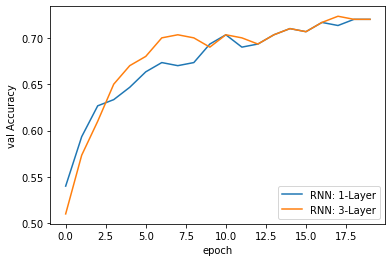

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=packed_train, label='RNN: 1-Layer')
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_results, label='RNN: 3-Layer')

## Bidirectional RNNs

A more sophisticated improvement to the RNN is to create a _bi-directional_ RNN. You may have noticed our RNNs always go from left to right, but this can make learning challenging. What if the information we need occurs near the front of the input sequence? The RNN needs to make sure that information "survives" multiple time steps, where each time step is an opportunity for noise to be introduced, or for other information to otherwise "obscure" the past. 

A good way to think about why retaining information over time  is hard is to image an extreme scenario. Say you have only 32 neurons in your RNN layer, but the time series is _1 billion steps long_. The information in an RNN exists entirely within the "universe" of only 32 values, which is simply not enough to keep information intact after a billion operations! 

To make this easier, we can have the RNN traverse the input in _both_ directions at once, and _share_ this information with the next layer of the RNN. This means at the 2nd layer of the RNN, time step 1 now has _some_ information about time step $T$. This starts to accumulate information about time more evenly through the RNN, and can make learning easier. 


![Bidirectional RNN. The output of each step in time goes to two RNNs. One processing input left-to-right (green) and the other from right-to-left (red). The output of the two RNNs is combined (via concatenation) to create one new item at each step. This item then goes to two outputs. ](https://drive.google.com/uc?export=view&id=1dgoXFkWhU8oT4GTNj9WDH79q4yNzRT9P)

Notice that the _last_ time step now comes partially from the left-most and right-most item in the sequence! Our `LastTimeStep` function already handles that for us, which is why we did the work of implementing it. It allows us to seamlessly handle this new feature. 

As before, implementing bidirectional RNNs efficiently and accurately is no easy task! Luckily, PyTroch again makes this very easy. Simply set the `bidirectional=True` flag! Note though, that our final hidden state is actually _twice as large_ now. This is because we have the final activations from _each_ direction, so our `LastTimeStep` will have twice as many values as expected! As long as we remember to multiple the `hidden_nodes*2` in the the final `nn.Linear` layer, this will still work with little changes. The new code is below. 


In [ ]:
rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(57, 64)
  )
  (1): RNN(64, 256, num_layers=3, batch_first=True, bidirectional=True)
  (2): LastTimeStep()
  (3): Linear(in_features=512, out_features=18, bias=True)
)

In [ ]:
rnn_3layer_bidir_results = train_simple_network(rnn_3layer_bidir, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20, lr=0.01)

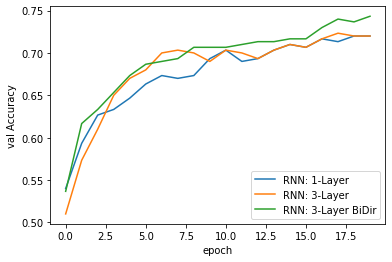

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=packed_train, label='RNN: 1-Layer')
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_results, label='RNN: 3-Layer')
sns.lineplot(x='epoch', y='val Accuracy', data=rnn_3layer_bidir_results, label='RNN: 3-Layer BiDir')

The results are shown in the above figure, where the bidirectional RNN has a clear advantage now. Whenever possible, you will almost always want to use a bidirectional RNN, as it makes learning the access information across time much easier for the network. This has lead to an increase in accuracy for our simple problem. But, there will be cases where you do not or can not use a bidirectional version. Such examples will come later in the book. 

# Exercises 

1. Modify  `LanguageNameDataset` the so that the `vocabulary` object in the constructor does not need to be passed in as an argument, but instead can be _inferred_ from the input dataset. This means you will need to iterate through the dataset, and create a dictionary with all of the characters _actually seen_. One way to implement this is to create a default value  `vocabulary=None`, and use `is vocabulary None:` to change behavior. 
2. Update the `LanguageNameDataset` with a flag in the constructor for `unicode=False`. You should change any of the code you need to so that when `unicode=True`, the `LanguageNameDataset` will instead keep all the unicode characters seen when `vocabulary=None` (this depends on question 1). Train a new RNN classifier with `unicode=True`, how does it impact the results?
3. Again, update the  `LanguageNameDataset` with a new `min_count=1` argument in the constructor. If `vocabulary=None`, it should replace any character that occurs too few times with a special `"UNK"` token, indicating an "unkown" value. How is the size of the vocabulary impacted by setting the `min_count=300` and what happens to the results? 
4. The original training/test split for this task was created by randomly sampling the dataset. Create your own function that performs _stratified_ splitting. This means it will select a test set that has the exact same proportions of each class. How does this impact your apparent results?
5. Replace the last output layer `nn.Linear(hidden_nodes, classes)` from the RNN implementation with a fully-connected network with 2 hidden layers and one output layer. How does this impact the accuracy of the model?
6. You can use the collate function to implement interesting features. To get a better handle on how it works, implement your own `collate_fn` that removes half of the items from a batch of training data. Does training with two epochs of this model obtain the same results as training with one epoch of a normal `collate_fn`? Why or why not?
7. Compare training a 3-layer bidirectional RNN with batch sizes of $B=\{1, 2, 4, 8\}$ for 5 epochs. Which batch size seems to give the best balance between speed and accuracy? 